In [2]:
import pandas as pd
import numpy as np

## Load Data

In [3]:
mega_fd = pd.read_csv("cleaned_data.csv")
print("Loaded cleaned data with shape:", mega_fd.shape)

Loaded cleaned data with shape: (19113, 30)


## Catigorize Columns

In [4]:
# Remove ClosePrice column
features = mega_fd.drop(columns=['ClosePrice'])

# Define numerical columns first
num_cols = features.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical columns identified:", num_cols)

Numerical columns identified: ['Latitude', 'Longitude', 'LivingArea', 'DaysOnMarket', 'ParkingTotal', 'YearBuilt', 'BathroomsTotalInteger', 'BedroomsTotal', 'Stories', 'LotSizeArea', 'MainLevelBedrooms', 'GarageSpaces', 'AssociationFee', 'LotSizeSquareFeet']


## Predicting Close Price

### KNN - Numerical variables only

In [5]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score

df_knn = mega_fd[num_cols + ['ClosePrice']].dropna()

X = df_knn[num_cols]
y = df_knn['ClosePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"KNN MAPE: {mape:.3f}")
print(f"KNN R-squared: {r2:.3f}")

KNN MAPE: 0.430
KNN R-squared: 0.317


### KNN - With categorical variables

In [6]:
# with categorical variables
df_no_null_cols = mega_fd.dropna(axis=1)

feature_cols = [col for col in df_no_null_cols.columns if col != 'ClosePrice']

df_no_null_cols = df_no_null_cols.dropna(subset=['ClosePrice'])

X = df_no_null_cols[feature_cols]
y = df_no_null_cols['ClosePrice']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"KNN MAPE (all columns, no nulls): {mape:.2f}")
print(f"KNN R-squared (all columns, no nulls): {r2:.3f}")

KNN MAPE (all columns, no nulls): 0.43
KNN R-squared (all columns, no nulls): 0.272


### Random Forest - numerical only

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Use only numerical columns for fair comparison
num_cols = [col for col in num_cols if col != 'ClosePrice']
df_num_model = mega_fd[num_cols + ['ClosePrice']].dropna()

# Remove top and bottom 1% outliers based on ClosePrice
q1 = df_num_model['ClosePrice'].quantile(0.01)
q99 = df_num_model['ClosePrice'].quantile(0.99)
df_num_model_filtered = df_num_model[(df_num_model['ClosePrice'] >= q1) & (df_num_model['ClosePrice'] <= q99)]

X = df_num_model_filtered[num_cols]
y = df_num_model_filtered['ClosePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Random Forest MAPE (outliers removed): {mape:.2f}")
print(f"Random Forest R-squared (outliers removed): {r2:.3f}")


Random Forest MAPE (outliers removed): 0.11
Random Forest R-squared (outliers removed): 0.866


### XGBoost - numerical only

In [8]:
import xgboost as xgb

# Use only numerical columns for fair comparison (same as rf)
X = df_num_model_filtered[num_cols]
y = df_num_model_filtered['ClosePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_reg = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"XGBoost MAPE (outliers removed): {mape:.2f}")
print(f"XGBoost R-squared (outliers removed): {r2:.3f}")

XGBoost MAPE (outliers removed): 0.12
XGBoost R-squared (outliers removed): 0.875


### LightGBM - numerical only

In [9]:
import lightgbm as lgb

# Use the same features and target as previous models
X = df_num_model_filtered[num_cols]
y = df_num_model_filtered['ClosePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_reg = lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)
lgb_reg.fit(X_train, y_train)

y_pred = lgb_reg.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"LightGBM MAPE (outliers removed): {mape:.2f}")
print(f"LightGBM R-squared (outliers removed): {r2:.3f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1989
[LightGBM] [Info] Number of data points in the train set: 14991, number of used features: 14
[LightGBM] [Info] Start training from score 1032721.465396
LightGBM MAPE (outliers removed): 0.12
LightGBM R-squared (outliers removed): 0.868


## Feature Selection for XGBoost

## Still numerical only

Performing hyperparameter tuning...
Best parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validation score: 0.11616880024069133
Tuned XGBoost MAPE: 0.107
Tuned XGBoost R-squared: 0.879

Top 10 Most Important Features:
                  feature  importance
6   BathroomsTotalInteger    0.341517
2              LivingArea    0.199954
1               Longitude    0.142324
0                Latitude    0.113011
12         AssociationFee    0.055950
13      LotSizeSquareFeet    0.029949
11           GarageSpaces    0.020059
10      MainLevelBedrooms    0.017591
9             LotSizeArea    0.017129
5               YearBuilt    0.017028


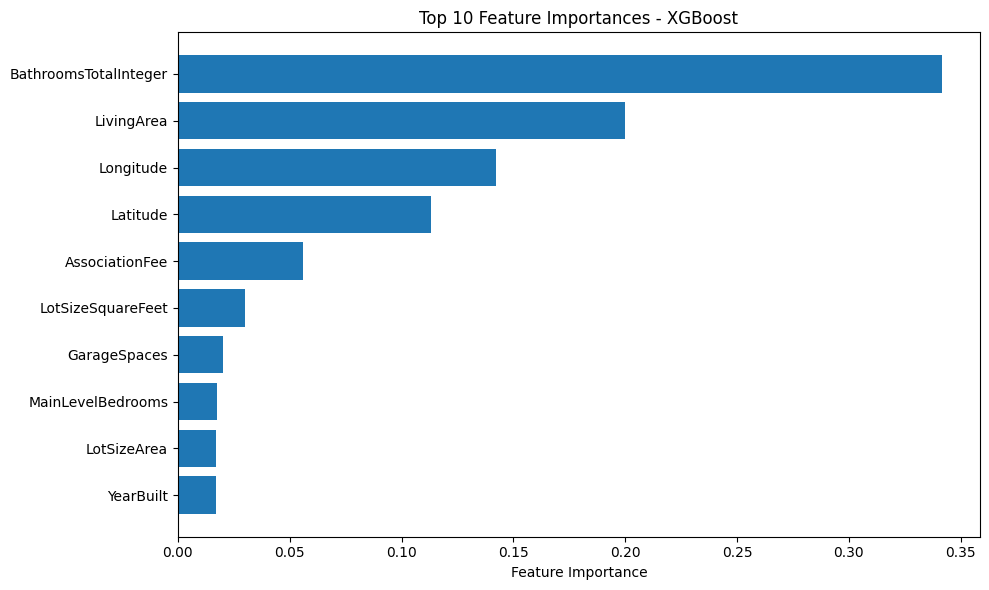

In [10]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Use the same data as before
X = df_num_model_filtered[num_cols]
y = df_num_model_filtered['ClosePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Feature scaling (can help with some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Start with a smaller grid for faster execution
param_grid_small = {
    'n_estimators': [100, 200],
    'max_depth': [6, 9],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0]
}

print("Performing hyperparameter tuning...")
xgb_reg = xgb.XGBRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(xgb_reg, param_grid_small, cv=3, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", -grid_search.best_score_)

# 3. Train final model with best parameters
best_xgb = grid_search.best_estimator_
y_pred_tuned = best_xgb.predict(X_test)

mape_tuned = mean_absolute_percentage_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)
print(f"Tuned XGBoost MAPE: {mape_tuned:.3f}")
print(f"Tuned XGBoost R-squared: {r2_tuned:.3f}")

# 4. Feature importance analysis
feature_importance = best_xgb.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df.head(10)['feature'], importance_df.head(10)['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Add categorical

Categorical Feature Importance (Mutual Information):
              feature  importance
9          PostalCode    0.758306
5                City    0.595162
8  HighSchoolDistrict    0.590819
3      CountyOrParish    0.359528
0            Flooring    0.108951
1     UnparsedAddress    0.059049
7              Levels    0.057556
2        PropertyType    0.000000
4     PropertySubType    0.000000
6     StateOrProvince    0.000000


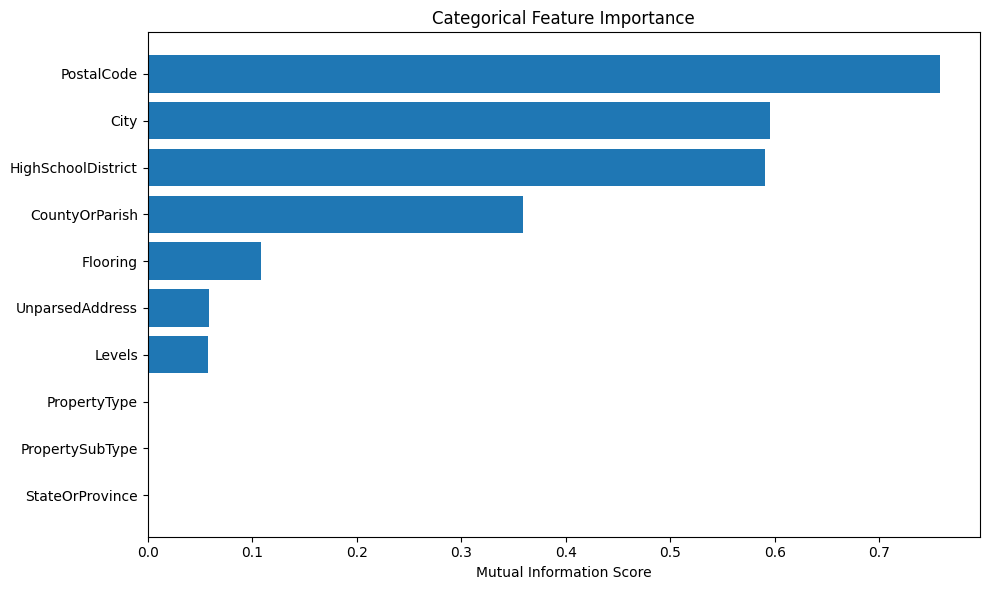

In [14]:
# Feature selection for categorical variables
def categorical_feature_importance(df, categorical_cols, target_col):
    """Calculate feature importance for categorical variables using mutual information"""
    cat_importance = {}
    
    for col in categorical_cols:
        # Encode categorical variable
        le = LabelEncoder()
        encoded_col = le.fit_transform(df[col].astype(str))
        
        # Calculate mutual information
        mi_score = mutual_info_regression(encoded_col.reshape(-1, 1), df[target_col], random_state=42)[0]
        cat_importance[col] = mi_score
    
    return cat_importance

# Calculate importance for categorical features
cat_importance = categorical_feature_importance(df_processed, categorical_cols, 'ClosePrice')
cat_importance_df = pd.DataFrame(list(cat_importance.items()), columns=['feature', 'importance'])
cat_importance_df = cat_importance_df.sort_values('importance', ascending=False)

print("Categorical Feature Importance (Mutual Information):")
print(cat_importance_df)

# Plot categorical feature importance
if len(categorical_cols) > 0:
    plt.figure(figsize=(10, 6))
    plt.barh(cat_importance_df['feature'], cat_importance_df['importance'])
    plt.xlabel('Mutual Information Score')
    plt.title('Categorical Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [38]:
# Combine and select best features
def select_best_features(num_importance_df, cat_importance_df, top_n_num=15, top_n_cat=5):
    """Select top features from both numerical and categorical"""
    
    # Get top numerical features
    top_num_features = num_importance_df.head(top_n_num)['feature'].tolist()
    
    # Get top categorical features
    top_cat_features = cat_importance_df.head(top_n_cat)['feature'].tolist()
    
    return top_num_features, top_cat_features

# Select best features
top_num_features, top_cat_features = select_best_features(num_importance_df, cat_importance_df, 7)

print(f"Selected {len(top_num_features)} numerical features:")
print(top_num_features)
print(f"\nSelected {len(top_cat_features)} categorical features:")
print(top_cat_features)

# Prepare data for modeling
selected_features = top_num_features + top_cat_features
df_selected = df_processed[selected_features + ['ClosePrice']].copy()

# One-hot encode categorical variables
df_final = pd.get_dummies(df_selected, columns=top_cat_features, drop_first=True)

print(f"\nFinal dataset shape after feature selection and encoding: {df_final.shape}")
print(f"Final features: {len(df_final.columns) - 1}")

Selected 7 numerical features:
['LivingArea', 'BathroomsTotalInteger', 'BedroomsTotal', 'AssociationFee', 'Stories', 'GarageSpaces', 'Latitude']

Selected 5 categorical features:
['PostalCode', 'City', 'HighSchoolDistrict', 'CountyOrParish', 'Flooring']

Final dataset shape after feature selection and encoding: (19113, 1962)
Final features: 1961


In [39]:
# Train XGBoost with selected features
from sklearn.model_selection import cross_val_score

# Remove outliers (same as before)
q1 = df_final['ClosePrice'].quantile(0.01)
q99 = df_final['ClosePrice'].quantile(0.99)
df_final_filtered = df_final[(df_final['ClosePrice'] >= q1) & (df_final['ClosePrice'] <= q99)]

# Prepare features and target
X_all = df_final_filtered.drop(columns=['ClosePrice'])
y_all = df_final_filtered['ClosePrice']

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

# default XGBoost model
xgb_default = xgb.XGBRegressor(random_state=42, n_jobs=-1)
xgb_default.fit(X_train_all, y_train_all)
y_pred_default = xgb_default.predict(X_test_all)
mape_default = mean_absolute_percentage_error(y_test_all, y_pred_default)
r2_default = r2_score(y_test_all, y_pred_default)
print(f"Default XGBoost MAPE: {mape_default:.3f}")
print(f"Default XGBoost R-squared: {r2_default:.3f}")


Default XGBoost MAPE: 0.128
Default XGBoost R-squared: 0.866


In [40]:
# Hyperparameter tuning for XGBoost with all features
# param_grid_comprehensive = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [6, 8, 10],
#     'learning_rate': [0.05, 0.1, 0.15],
#     'subsample': [0.8, 0.9],
#     'colsample_bytree': [0.8, 0.9]
# }
param_grid_fast = {
    'n_estimators': [100],
    'max_depth': [6, 8],
    'learning_rate': [0.1, 0.2, 0.3],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

print("Performing fast hyperparameter tuning...")
xgb_fast = xgb.XGBRegressor(random_state=42, n_jobs=-1)
grid_search_all = GridSearchCV(
    xgb_fast, 
    param_grid_fast, 
    cv=5, 
    scoring='neg_mean_absolute_percentage_error', 
    n_jobs=-1,
    verbose=1
)

grid_search_all.fit(X_train_all, y_train_all)

print("Best parameters:", grid_search_all.best_params_)
print("Best cross-validation score:", -grid_search_all.best_score_)

# Train final model
best_xgb_all = grid_search_all.best_estimator_
y_pred_all = best_xgb_all.predict(X_test_all)

mape_all = mean_absolute_percentage_error(y_test_all, y_pred_all)
r2_all = r2_score(y_test_all, y_pred_all)

print(f"\nXGBoost with All Features:")
print(f"MAPE: {mape_all:.3f}")
print(f"R-squared: {r2_all:.3f}")

# Cross-validation scores
cv_scores = cross_val_score(best_xgb_all, X_train_all, y_train_all, 
                           cv=5, scoring='neg_mean_absolute_percentage_error')
print(f"CV MAPE: {-cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

Performing fast hyperparameter tuning...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


Best parameters: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation score: 0.12701721700544072

XGBoost with All Features:
MAPE: 0.123
R-squared: 0.863
CV MAPE: 0.127 (+/- 0.003)
CV MAPE: 0.127 (+/- 0.003)
